C:\Users\gl8304\AppData\Local\Temp\ipykernel_12032\1234752009.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


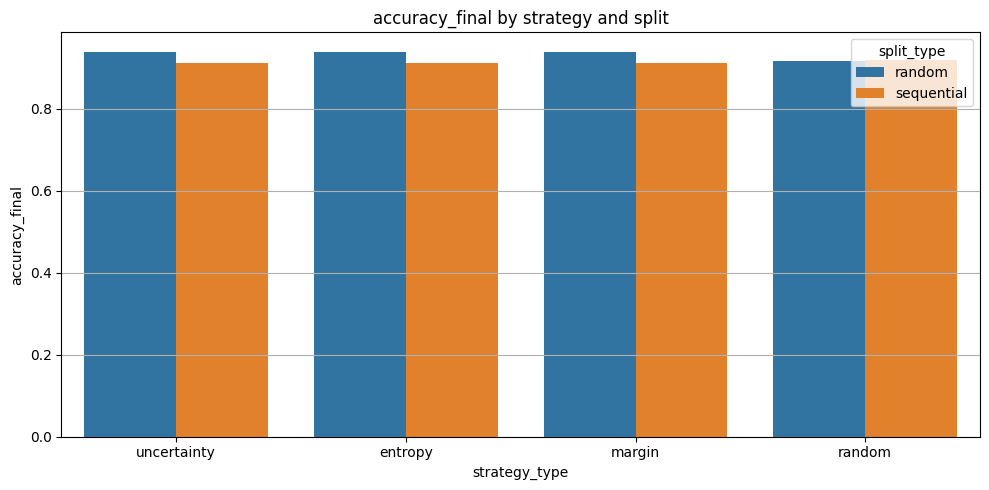

C:\Users\gl8304\AppData\Local\Temp\ipykernel_12032\1234752009.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


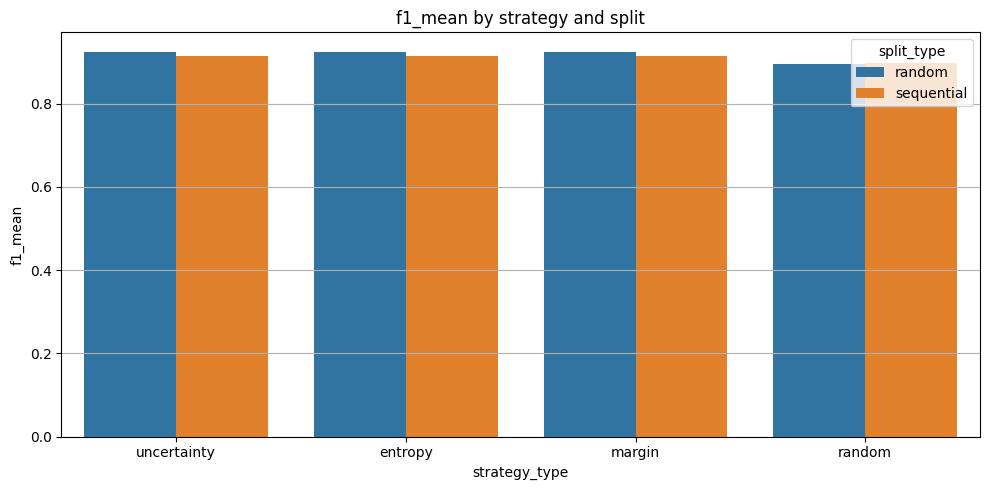

C:\Users\gl8304\AppData\Local\Temp\ipykernel_12032\1234752009.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


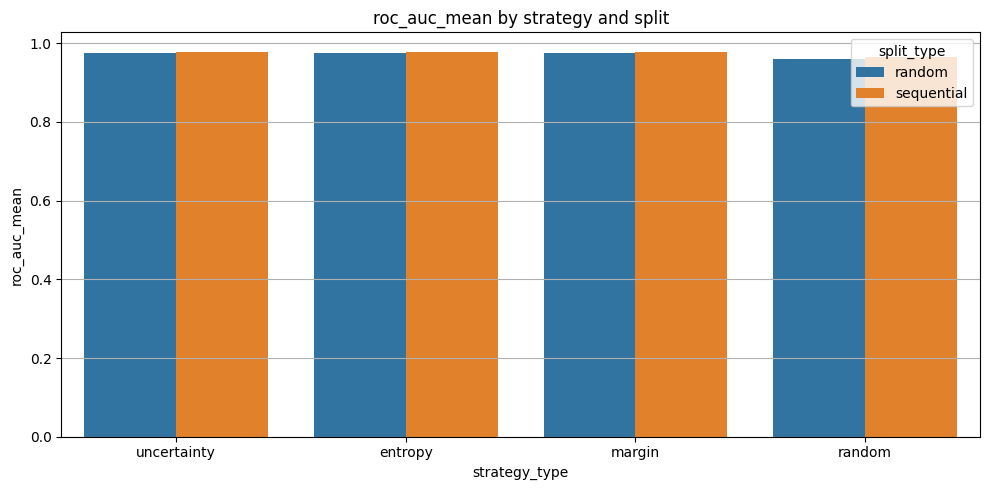

C:\Users\gl8304\AppData\Local\Temp\ipykernel_12032\1234752009.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


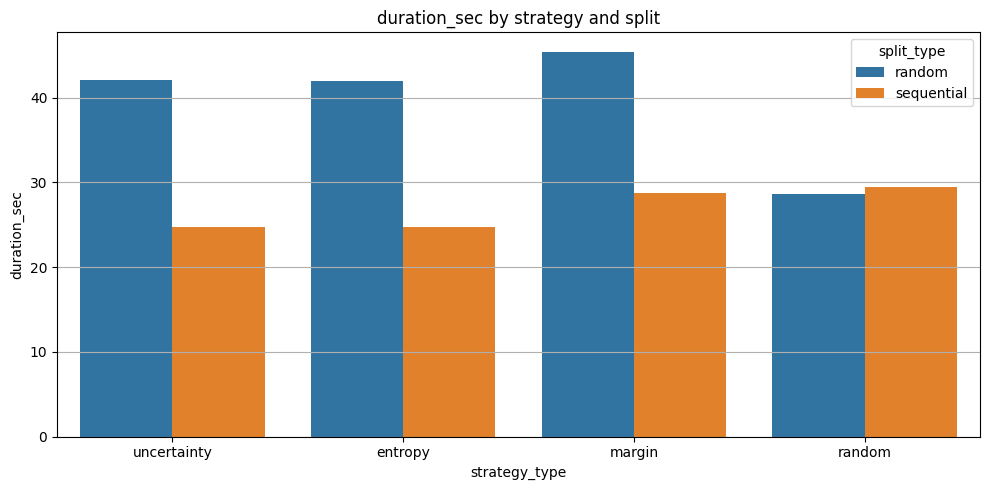

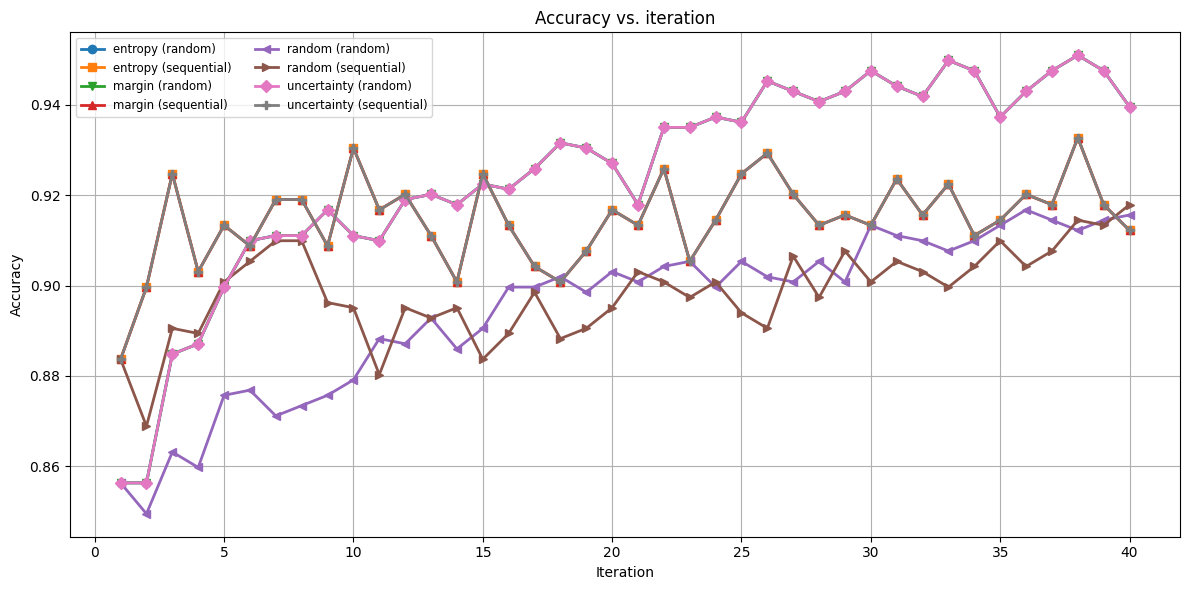

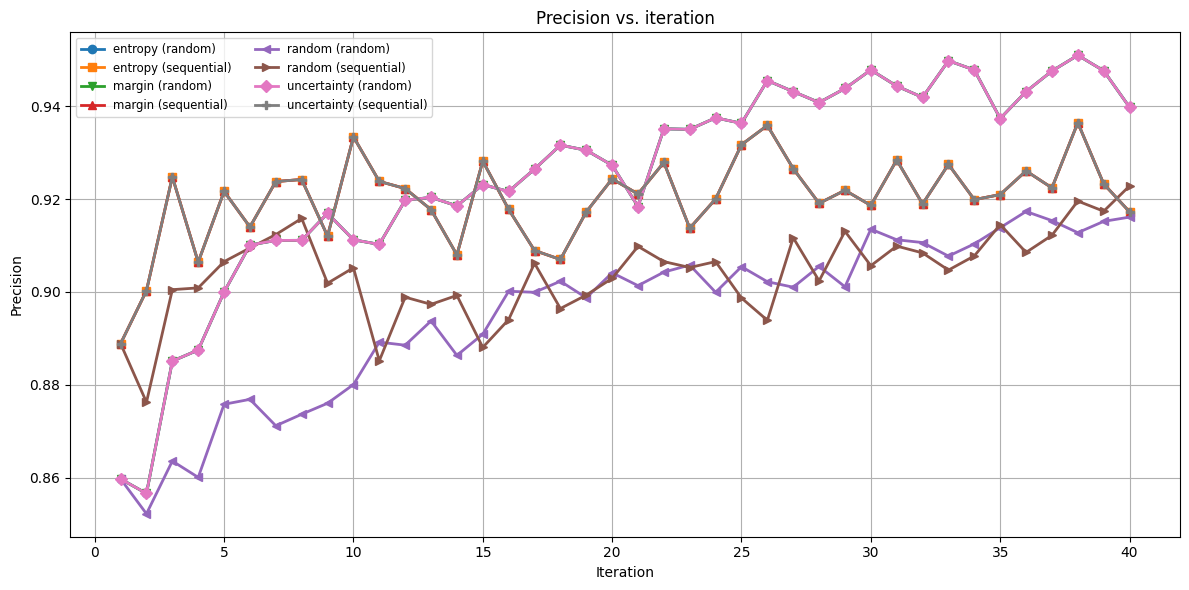

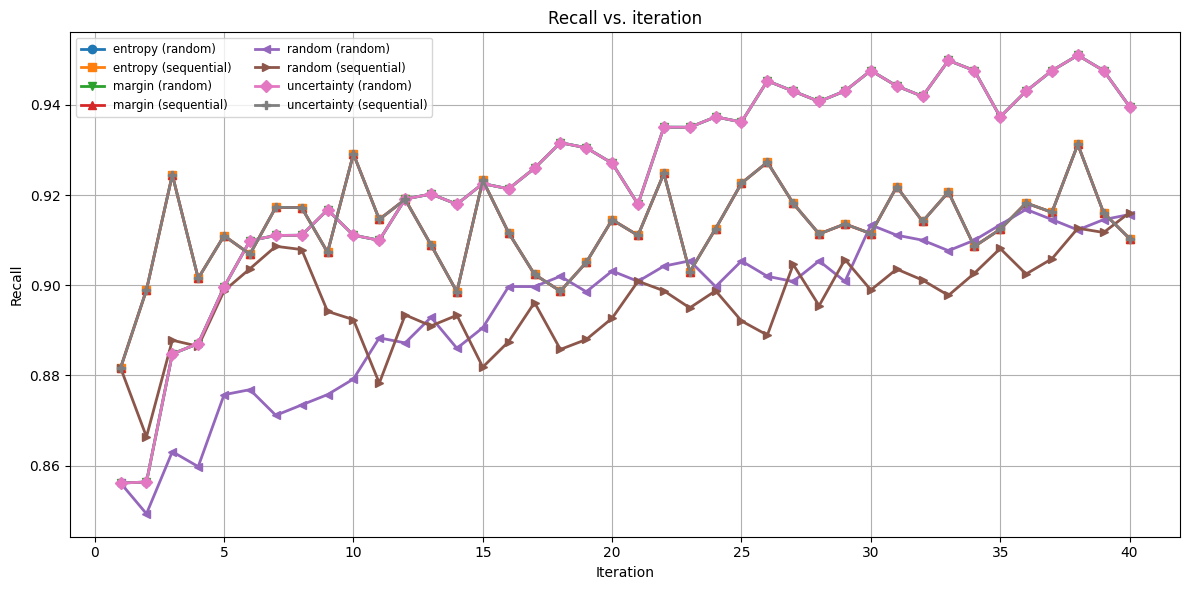

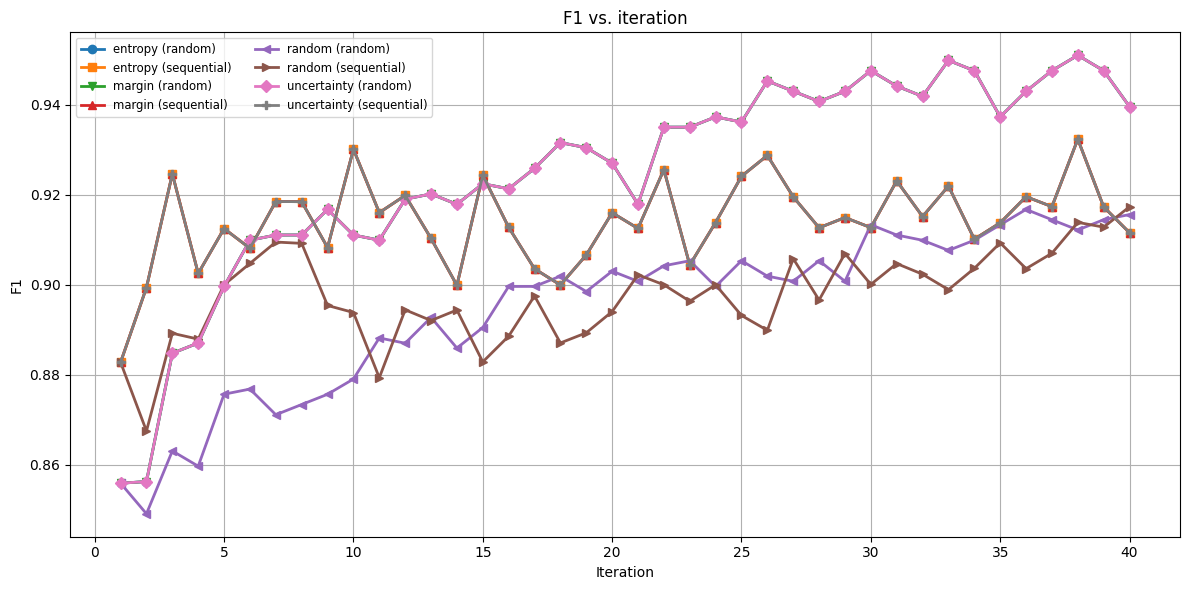

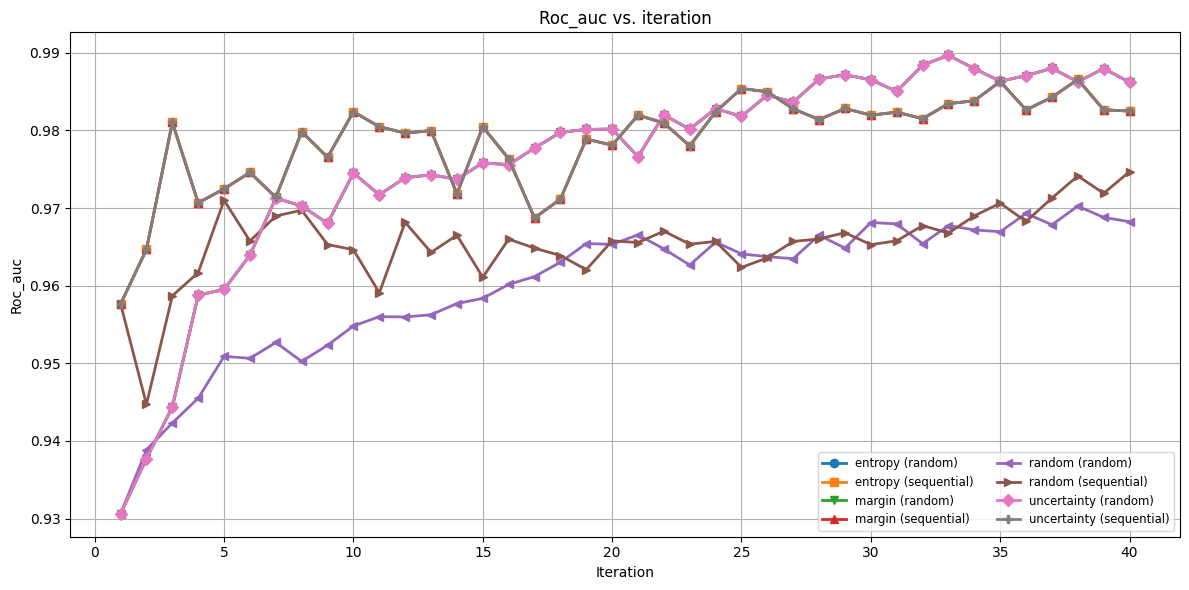

,strategy_type,split_type,accuracy_final,f1_mean,roc_auc_mean,duration_sec
0,uncertainty,random,0.939567,0.924981,0.976174,42.092468
1,entropy,random,0.939567,0.924981,0.976174,41.939640
2,margin,random,0.939567,0.924981,0.976174,45.445109
7,random,sequential,0.917902,0.897618,0.965590,29.447162
3,random,random,0.915621,0.894746,0.959962,28.638078
4,uncertainty,sequential,0.912201,0.914142,0.978897,24.794889
5,entropy,sequential,0.912201,0.914142,0.978897,24.702323
6,margin,sequential,0.912201,0.914142,0.978897,28.730239


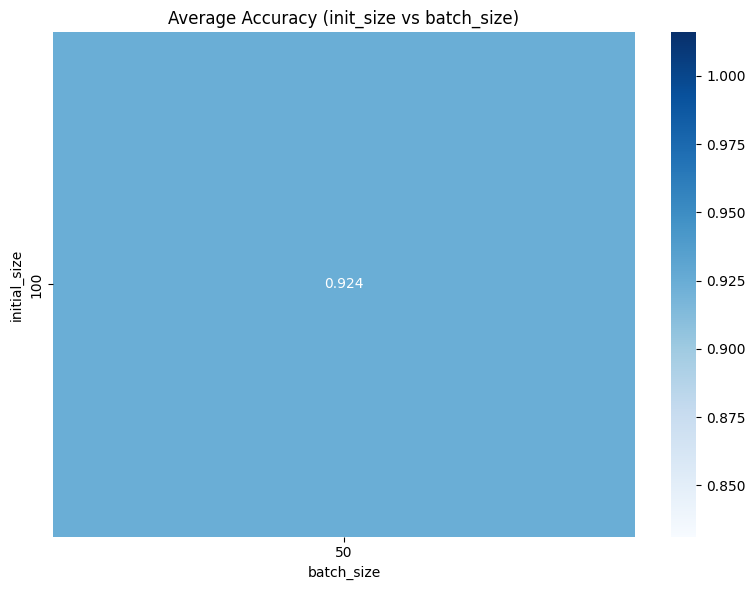

In [26]:
import os
import pandas as pd
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
TABLES_DIR = os.path.join(BASE_DIR, "tables")
FIGURES_DIR = os.path.join(BASE_DIR, "figures")

# Poišči najnovejši CSV
def find_latest_file(pattern: str, directory: str) -> str:
    files = glob(os.path.join(directory, pattern))
    if not files:
        raise FileNotFoundError(f"No files matching {pattern} in {directory}")
    return max(files, key=os.path.getctime)

results_csv = find_latest_file("active_learning_results_*.csv", TABLES_DIR)
detailed_csv = find_latest_file("al_metrics_per_iteration_*.csv", TABLES_DIR)

# Naloži podatke
results_df = pd.read_csv(results_csv)
detailed_df = pd.read_csv(detailed_csv)

# Grafi metrik na koncu (summary)
metrics = ["accuracy_final", "f1_mean", "roc_auc_mean", "duration_sec"]
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=results_df,
        x="strategy_type", y=metric,
        hue="split_type", ci=None
    )
    plt.title(f"{metric} by strategy and split")
    plt.grid(True, axis='y')
    plt.tight_layout()
    fname = os.path.join(FIGURES_DIR, f"summary_{metric}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(fname)
    plt.show()


# Izberi prepoznavne barve in markerje
palette = sns.color_palette("tab10", 8)
markers = ['o', 's', 'v', '^', '<', '>', 'D', 'P']

iter_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

grouped_df = detailed_df.copy()

for metric in iter_metrics:
    plt.figure(figsize=(12, 6))
    for idx, ((strategy, split), group) in enumerate(grouped_df.groupby(["strategy_type", "split_type"])):
        group_sorted = group.sort_values("iteration_id")

        # Zelo jasno ločljive linije
        plt.plot(
            group_sorted["iteration_id"],
            group_sorted[metric],
            label=f"{strategy} ({split})",
            color=palette[idx % len(palette)],
            marker=markers[idx % len(markers)],
            linewidth=2,
            markersize=6
        )

    plt.title(f"{metric.capitalize()} vs. iteration")
    plt.xlabel("Iteration")
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.legend(loc="best", fontsize='small', ncol=2)
    plt.tight_layout()
    fname = os.path.join(FIGURES_DIR, f"trend_{metric}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(fname)
    plt.show()

# Povzetek v tabeli
summary = results_df[[
    "strategy_type", "split_type", "accuracy_final",
    "f1_mean", "roc_auc_mean", "duration_sec"
]].sort_values(by="accuracy_final", ascending=False)
display(summary)

# Heatmap za accuracy
pivot = results_df.pivot_table(
    index="initial_size", columns="batch_size", values="accuracy_final", aggfunc="mean"
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
plt.title("Average Accuracy (init_size vs batch_size)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f"heatmap_accuracy_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
plt.show()